Discussion

1) the motivation behind the presented solutions

2) how you represent and preprocess the data

Task 1
Stop words: Here, the stop_words parameter is set to 'english' to remove common English words that are not typically useful for classification. 
Strip_accents: is set to 'ascii' to remove accents from characters in the text, which can be important for maintaining consistency across different languages or text sources.

Performed quite similarly, didn't do anything using the two above, leave them in for practical purposes.

Task 2
- Venue name: countVectorisation using stop words and strip accents
- Mean check-in time: binning checkin times by the hour

3) your idea and solution implementation for each of the two tasks listed above.

Task 1
- Fit baseline naive bayes model. Performed the worst. 
- Adding some preprocessing (as mentioned above) allowed it to perform slightly better
- Balanced classes using over and undersampling performed roughly the same. Issues with loosing information from undersampling majority classes and introducing bias from oversampling minority classes.
- Compliment Naive Bayes can deal with class imbalance through.... performs the best, but not significantl better. Extra performance with preprocessing from model 2.

All perform reletively similar.. however compliment naive bayes was better.. it might be best to add other variables into the model which might be helpful, so we look at Task 2.

Task 2
- EDA to identify features. Using logic and analysis to make decisions.
    - No difference in distribution between lat and lon between the 3 classes... probably not a really useful variable.
    - EDIT: NEED TO CLARIFY WHAT MEAN CHECKIN TIME MEANS. Mean checkin time could give us an indication of when the person could've possibly accessed the venue, however this assumes that the person reviews the business right after their experience there... which is a strong assumption.
    - Venue name could logically be a stronger feature to identify venue type
- 

4) the evaluation procedure (e.g., cross-validation or training/validation split)

Preprocessing: piping to avoid information leakage between training and validation sets
- countvectorisation()
- over/under sampling minority/majority class

Strat CV
- data is split in a way that maintains the proportion of instances of each class in each fold. used when testing with imbalanced data
- improves performance slightly compared to normal CV
- Talk about n-folds and n-repeats

GridsearchCV: Searches Gridspace and does CV for each combination of hyperparameters and preprocessing parameters
- Using prior probabilities or not
- Laplace smoothing alpha value (to limit naives bayes equation denom/numer to drive to 0 for certain predictions when we get 0 instances of a word appearing given the class label)

5) the training/validation results. 

Ooo, probably need to pay attention this and look at how we report accuracy...

Notes
- Assume test and train data come from the same distribution, so we split the training set into a further training and test set




Task 1: Using Review data to Model Venue Category

In [1]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from scipy import sparse

import pandas as pd
import numpy as np

import seaborn as sns
import folium
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [2]:
k_folds = 5
rs = 951

In [3]:
yelp_df = pd.read_csv('../data/input/train.csv')
yelp_test_df = pd.read_csv('../data/input/test.csv')

X = yelp_df["review"]
y = yelp_df["category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rs)

Exploratory Data Analysis on Review Data

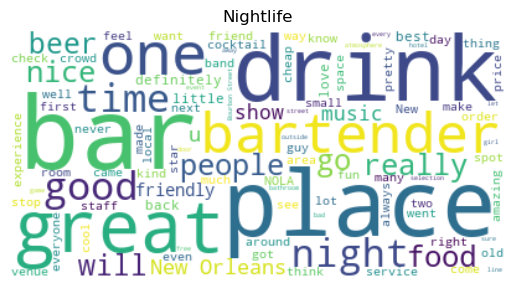

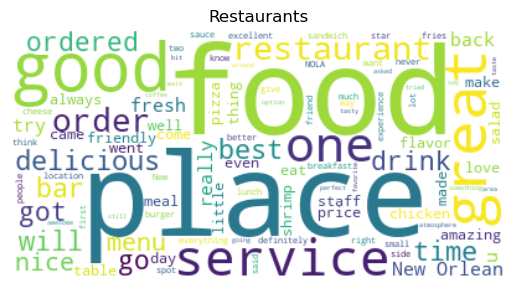

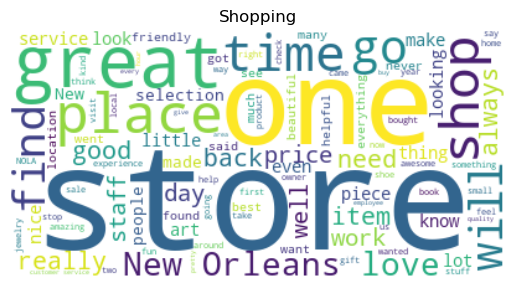

In [4]:
# Subset the data to only include venue name and category columns
df = yelp_df[['review', 'category']]

# Group the venue names by their associated category
grouped = df.groupby('category')

# Create a WordCloud for each category
for category, group in grouped:
    # Concatenate all venue names for this category into one string
    text = ' '.join(group['review'].tolist())
    # Create a WordCloud object with desired parameters
    wc = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue')
    # Generate the WordCloud image
    wc.generate(text)
    # Create a matplotlib plot of the WordCloud
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(category)
    plt.show()

Distribution of common words in each class label seems reasonable. No need to preprocess any usual words.We can deal with stop words later.

Model 1: Implement Multinomial Naive Bayes with Unpreprocessed Data

In [5]:
params = {
    'clf__alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    'clf__fit_prior': [True, False]
}

# where our k-folds will be independantly piped into (1 fold count vectorised independantly of the other 9 folds) this ensures no information leakage between the training and validation sets
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

# data is split in a way that maintains the proportion of instances of each class in each fold. used when testing with imbalanced data
cv_struct = RepeatedStratifiedKFold(n_splits = k_folds, n_repeats=1, random_state=rs)

grid_search = GridSearchCV(pipeline, params, cv=cv_struct, scoring='accuracy')
grid_search.fit(X_train, y_train)

# gather best hyperparameters, best model use standard deviation for an estimate on how 
print("Best hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
best_model = grid_search.best_estimator_

# predictions
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
mean_accuracy = test_accuracy.mean()

# crude estimation of percentage standard deviation based on test accuracy and standard deviation from cross-validation
percent_std_dev = std_dev / mean_accuracy * 100

print('Test accuracy:', round(test_accuracy * 100, 4), " %")
print('Standard deviation:', round(percent_std_dev, 4), " %")

Best hyperparameters:  {'clf__alpha': 0.5, 'clf__fit_prior': False}
Test accuracy: 87.1479  %
Standard deviation: 0.7566  %


Poor performance. Below baseline.

Model 2: Implement Multinomial Naive Bayes with Preprocessing (Stop Words, and Strip Accents)

In [6]:
params = {
    'clf__alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    'clf__fit_prior': [True, False]
}

# where our k-folds will be independantly piped into (1 fold count vectorised independantly of the other 9 folds) this ensures no information leakage between the training and validation sets
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents = "ascii")),
    ('clf', MultinomialNB())
])

# data is split in a way that maintains the proportion of instances of each class in each fold. used when testing with imbalanced data
cv_struct = RepeatedStratifiedKFold(n_splits = k_folds, n_repeats=1, random_state=rs)

grid_search = GridSearchCV(pipeline, params, cv=cv_struct, scoring='accuracy')
grid_search.fit(X_train, y_train)

# gather best hyperparameters, best model use standard deviation for an estimate on how 
print("Best hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
best_model = grid_search.best_estimator_

# predictions
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
mean_accuracy = test_accuracy.mean()

# crude estimation of percentage standard deviation based on test accuracy and standard deviation from cross-validation
percent_std_dev = std_dev / mean_accuracy * 100

print('Test accuracy:', round(test_accuracy * 100, 4), " %")
print('Standard deviation:', round(percent_std_dev, 4), " %")

Best hyperparameters:  {'clf__alpha': 0.5, 'clf__fit_prior': False}
Test accuracy: 87.1479  %
Standard deviation: 1.146  %


Slightly better performance using stop words and split accents. Could be useful when implemented on large dataset sets.

Let's evaluate how balanced our class labels are...

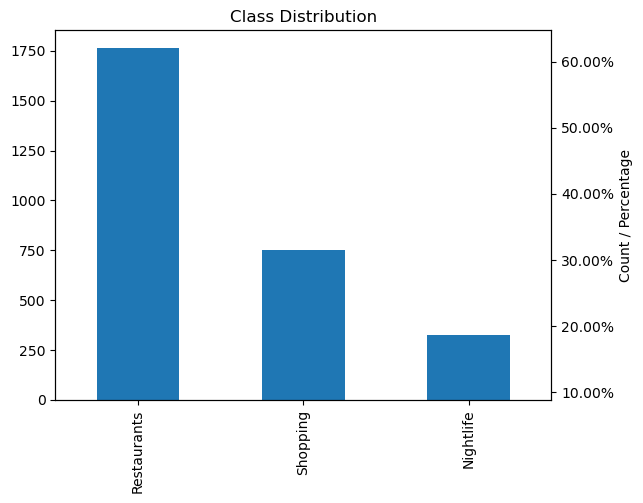

In [7]:
class_counts = y.value_counts()
# calculate the percentage of each class
class_percentages = (class_counts / class_counts.sum()) * 100

# create a bar plot of the categorical class distribution with percentages
fig, ax = plt.subplots()
class_counts.plot(kind='bar', ax=ax)
ax2 = ax.twinx()
class_percentages.plot(kind='line', color='red', ax=ax2, linestyle="None",marker='None')
ax2.yaxis.set_major_formatter('{x:.2f}%')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count / Percentage')
plt.show()

"Restaurants" appears to be the majority class label, taking up to 62% of the class, followed by "Shopping" at 26% then "Nightlife" at 11%. This is not ideal when model building as we will see inherent bias towards classifiying a venue as a "Restaurant" compared to "Shopping" or "Nightlife". This is because the prior probabilities of restaruant P(yres) will be higher than that of P(ynight) and P(yshop) purely due to class label distribution. I solve this by performing oversampling of our minority class labels.

Model 3: Implement Naive Bayes with Preprocessing and Over and Undersampling Class Labels

In [8]:
params = {
    # reduce alpha values for fast processing of gridsearchCV
    'clf__alpha': [0.5, 0.75, 1, 1.25, 1.5],
    'clf__fit_prior': [True, False],
    'over_sampler__sampling_strategy': ['not minority', 'not majority', 'minority', 'all'],
    'under_sampler__sampling_strategy': ['majority', 'not minority', 'not majority', 'all'],
}

# where our k-folds will be independantly piped into (1 fold count vectorised independantly of the other 9 folds) this ensures no information leakage between the training and validation sets
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents = "ascii")),
    ('over_sampler', RandomOverSampler()),
    ('under_sampler', RandomUnderSampler()),
    ('clf', MultinomialNB(alpha=0.5, fit_prior=True))
])

# data is split in a way that maintains the proportion of instances of each class in each fold. used when testing with imbalanced data
cv_struct = RepeatedStratifiedKFold(n_splits = k_folds, n_repeats=1, random_state=rs)

# search hyperparameter space
grid_search = GridSearchCV(pipeline, params, cv=cv_struct, scoring='accuracy')
grid_search.fit(X_train, y_train)

# gather best hyperparameters, best model use standard deviation for an estimate on how 
print("Best hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
best_model = grid_search.best_estimator_

# predictions
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
mean_accuracy = test_accuracy.mean()

# crude estimation of percentage standard deviation based on test accuracy and standard deviation from cross-validation
percent_std_dev = std_dev / mean_accuracy * 100

print('Test accuracy:', round(test_accuracy * 100, 4), " %")
print('Standard deviation:', round(percent_std_dev, 4), " %")

Best hyperparameters:  {'clf__alpha': 0.75, 'clf__fit_prior': False, 'over_sampler__sampling_strategy': 'all', 'under_sampler__sampling_strategy': 'not minority'}
Test accuracy: 85.3873  %
Standard deviation: 0.9287  %


Doesn't perform much better than other models. Try Compliment Naive Bayes as it is better with dealing with imbalanced classes without having to bootstrap samples or reduce samples.

Model 4: Compliment Naive Bayes with Preprocessing

In [13]:
params = {
    'cnb__alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    'cnb__fit_prior': [True, False]
}

# where our k-folds will be independantly piped into (1 fold count vectorised independantly of the other 9 folds) this ensures no information leakage between the training and validation sets
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents = "ascii")),
    ('cnb', ComplementNB())
])

# data is split in a way that maintains the proportion of instances of each class in each fold. used when testing with imbalanced data
cv_struct = RepeatedStratifiedKFold(n_splits = k_folds, n_repeats=1, random_state=7)

grid_search = GridSearchCV(pipeline, params, cv=cv_struct, scoring='accuracy')
grid_search.fit(X_train, y_train)

# gather best hyperparameters, best model use standard deviation for an estimate on how 
print("Best hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
best_model = grid_search.best_estimator_

# predictions
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
mean_accuracy = test_accuracy.mean()

# crude estimation of percentage standard deviation based on test accuracy and standard deviation from cross-validation
percent_std_dev = std_dev / mean_accuracy * 100

print('Test accuracy:', round(test_accuracy * 100, 4), " %")
print('Standard deviation:', round(percent_std_dev, 4), " %")

Best hyperparameters:  {'cnb__alpha': 1, 'cnb__fit_prior': True}
['Restaurants' 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants'
 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants'
 'Shopping' 'Restaurants' 'Shopping' 'Restaurants' 'Shopping' 'Shopping'
 'Nightlife' 'Shopping' 'Restaurants' 'Nightlife' 'Shopping' 'Restaurants'
 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants' 'Shopping'
 'Restaurants' 'Shopping' 'Shopping' 'Restaurants' 'Nightlife'
 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants'
 'Restaurants' 'Restaurants' 'Restaurants' 'Shopping' 'Restaurants'
 'Shopping' 'Restaurants' 'Shopping' 'Nightlife' 'Nightlife' 'Shopping'
 'Restaurants' 'Restaurants' 'Shopping' 'Nightlife' 'Restaurants'
 'Restaurants' 'Restaurants' 'Shopping' 'Shopping' 'Shopping'
 'Restaurants' 'Restaurants' 'Shopping' 'Restaurants' 'Shopping'
 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants'
 'Restaurants' 'Shopping' 'Shopping' 'R

In [14]:
final_model_task_1 = best_model
final_prediction_task_1 = final_model_task_1.predict(yelp_test_df["review"])
final_submission_task_1 = pd.DataFrame({'ID': yelp_test_df["ID"], 'category': final_prediction_task_1})

final_submission_task_1.to_csv('../data/output/submission_1.csv', index=False)

['Restaurants' 'Restaurants' 'Restaurants' 'Shopping' 'Restaurants'
 'Restaurants' 'Shopping' 'Restaurants' 'Shopping' 'Restaurants'
 'Shopping' 'Shopping' 'Restaurants' 'Shopping' 'Restaurants'
 'Restaurants' 'Restaurants' 'Nightlife' 'Shopping' 'Restaurants'
 'Restaurants' 'Nightlife' 'Restaurants' 'Shopping' 'Restaurants'
 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants' 'Nightlife'
 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants' 'Nightlife'
 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants'
 'Shopping' 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants'
 'Restaurants' 'Shopping' 'Shopping' 'Restaurants' 'Shopping' 'Shopping'
 'Shopping' 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants'
 'Shopping' 'Restaurants' 'Shopping' 'Shopping' 'Restaurants'
 'Restaurants' 'Restaurants' 'Restaurants' 'Restaurants' 'Shopping'
 'Shopping' 'Restaurants' 'Shopping' 'Restaurants' 'Shopping' 'Shopping'
 'Shopping' 'Restaurants' 'Restaurants' 'Restaurants

Task 2: Using Other Variables to Model Venue Category

Exploratory Data Analysis

In Task 2, we will like to add other variables into our Naive Bayes model (model 4). We will like to find the most useful variables, we can do this by exploratory data analysis. If numerical variables, latitude, longitude and mean check-in time have different distributions between the three class labels, then these variables are probably useful in our model. We use the whole training dataset to inspect this. We would also like to explore the frequencies of words in venue names, and decide whether that can be used in our model.

Coordinate Data

In [ ]:
# looking at the whole training dataset
# latitude 
sns.violinplot(x='category', y='latitude', data=yelp_df)

In [ ]:
# looking at the whole training dataset
# longitude 
sns.violinplot(x='category', y='longitude', data=yelp_df)

In [ ]:
# Create a map centered on the first review's coordinates
map = folium.Map(location=[yelp_df['latitude'][0], yelp_df['longitude'][0]], zoom_start=12)

# Loop through the reviews and add a marker for each one
for index, row in yelp_df.iterrows():
    # Add a marker for this review's location
    marker = folium.Marker(location=[row['latitude'], row['longitude']])
    marker.add_to(map)
map

It appears that there latitude and longitude have very similar distributions between the three class labels, therefore adding these variables into our model shouldn't make the model more accuracy. As shown on the map, we only get data for venues in New Orleans. Furthermore using geographic information to seperate between class labels is quite tricky as there are many other geographic information such as suburb, population, which might have a direct effect on the venue type. Using just the raw coordinates might introduce more noise, or possible overfitting to these particular locations. An idea would be to use the coordinates to get information such as suburb and demographic information using an API and using those variables in our model. However this is outside of the scope of this investigation.

Mean Check-in Time Data

In [ ]:
# looking at the whole training dataset
# mean checkin time 
sns.violinplot(x='category', y='mean_checkin_time', data=yelp_df, ylim=(0, 24))

For mean check-in time, each class label appears to have different distributions, therefore could be a useful variable to include into our model. Restaurants appears to be multimodal with centers at around the early morning and dinner time. Shopping appears to be mono modal with a center around 7pm. Whereas nightlight appears to be slightly multi-modal with the main center around 4am and the minor center around 7pm. This appears reasonable to what we would expect in reality. Since we are using Naive Bayes, one approach might be to bin each hour/half-hour/fifteen minutes and one-hot encode the bin for each instance.

Venue Name Data

In [ ]:
# Subset the data to only include venue name and category columns
df = yelp_df[['name', 'category']]

# Group the venue names by their associated category
grouped = df.groupby('category')

# Create a WordCloud for each category
for category, group in grouped:
    # Concatenate all venue names for this category into one string
    text = ' '.join(group['name'].tolist())
    # Create a WordCloud object with desired parameters
    wc = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue')
    # Generate the WordCloud image
    wc.generate(text)
    # Create a matplotlib plot of the WordCloud
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(category)
    plt.show()

It appears that there is some distinction between "Shopping", "Restaurant" and "Nightlife" venue names, so we can include it in our model. I would like to remove "Orleans" as this is geographic information which doesn't directly relate to venue type.

Model 5: Compliment Naive Bayes with Mean Check-In Time

In [ ]:
# recollect X data to contain mean check-in time
X = yelp_df[['mean_checkin_time', 'review']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rs)

In [ ]:
# binning and one-hot encoding function for mean check-in time
class BinMeanCheckInTime(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        bins = np.arange(0, 24, 0.5)
        binned = np.digitize(X, bins) - 1
        encoded = sparse.csr_matrix(np.eye(len(bins))[binned])
        return encoded

I chose a bin width of 30 minutes as there was no difference in model performance between using smaller bins. Larger bin size result in less features after one-hot encoding, therefore faster computing.

In [ ]:
params = {
    'cnb__alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    'cnb__fit_prior': [True, False]
}

# transforms each feature independantly according to specified rules
transformer = make_column_transformer(
    (BinMeanCheckInTime(), 'mean_checkin_time'),
    (CountVectorizer(stop_words='english', strip_accents= 'ascii'), 'review')
)

# where our k-folds will be independantly piped into (1 fold count vectorised independantly of the other 9 folds) this ensures no information leakage between the training and validation sets
pipeline = Pipeline([
    ('trans', transformer),
    ('cnb', ComplementNB())
])

# data is split in a way that maintains the proportion of instances of each class in each fold. used when testing with imbalanced data
cv_struct = RepeatedStratifiedKFold(n_splits = k_folds, n_repeats=1, random_state=7)

grid_search = GridSearchCV(pipeline, params, cv=cv_struct, scoring='accuracy')
grid_search.fit(X_train, y_train)

# gather best hyperparameters, best model use standard deviation for an estimate on how 
print("Best hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
best_model = grid_search.best_estimator_

# predictions
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
mean_accuracy = test_accuracy.mean()

# crude estimation of percentage standard deviation based on test accuracy and standard deviation from cross-validation
percent_std_dev = std_dev / mean_accuracy * 100

print('Test accuracy:', round(test_accuracy * 100, 4), " %")
print('Standard deviation:', round(percent_std_dev, 4), " %")

Model 5 is much more accurate after we use the mean checkin time. Keep that in our model

Model 6: Compliment Naive Bayes with Mean Check-In Time and Venue Name

In [ ]:
# recollect X data to contain mean check-in time and venue name
X = yelp_df[['name', 'mean_checkin_time', 'review']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rs)

In [ ]:
custom_stop_words = set(CountVectorizer(stop_words='english').get_stop_words())
custom_stop_words.add("Orleans")

params = {
    'cnb__alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    'cnb__fit_prior': [True, False]
}

# transforms each feature independantly according to specified rules
transformer = make_column_transformer(
    (BinMeanCheckInTime(), 'mean_checkin_time'),
    (CountVectorizer(stop_words=custom_stop_words, strip_accents= 'ascii'), 'name'),
    (CountVectorizer(stop_words='english', strip_accents= 'ascii'), 'review')
)

# where our k-folds will be independantly piped into (1 fold count vectorised independantly of the other 9 folds) this ensures no information leakage between the training and validation sets
pipeline = Pipeline([
    ('trans', transformer),
    ('cnb', ComplementNB())
])

# data is split in a way that maintains the proportion of instances of each class in each fold. used when testing with imbalanced data
cv_struct = RepeatedStratifiedKFold(n_splits = k_folds, n_repeats=1, random_state=7)

grid_search = GridSearchCV(pipeline, params, cv=cv_struct, scoring='accuracy')
grid_search.fit(X_train, y_train)

# gather best hyperparameters, best model use standard deviation for an estimate on how 
print("Best hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
best_model = grid_search.best_estimator_

# predictions
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
mean_accuracy = test_accuracy.mean()

# crude estimation of percentage standard deviation based on test accuracy and standard deviation from cross-validation
percent_std_dev = std_dev / mean_accuracy * 100

print('Test accuracy:', round(test_accuracy * 100, 4), " %")
print('Standard deviation:', round(percent_std_dev, 4), " %")

Including the venue name appears to increase accuracy. Did some preprocessing to include "Orleans" to the stop words. Didn't improve the accuracy.

Model 6 using Compliment Naive Bayes with Mean Check-In Time and Venue Name to predict venue category seems like the best model with the highest accuracy. I will submit this with the actual test data.

In [ ]:
final_model_task_2 = best_model
final_prediction_task_2 = final_model_task_2.predict(yelp_test_df)
final_submission_task_2 = pd.DataFrame({'ID': yelp_test_df["ID"], 'category': final_prediction_task_2})

final_submission_task_2.to_csv('../data/output/submission_2.csv', index=False)